In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

from datetime import datetime as dt, timedelta
import requests
import os
import pickle
import itertools

from itertools import cycle

from importlib import reload
# Use to do reload(load_data)

import load_data
import run_experiments

In [2]:
# get all parameter values
P_vals = run_experiments.P_vals
eps_vals = run_experiments.eps_vals
Ws = run_experiments.Ws
Ts = run_experiments.Ts
params = list(itertools.product(eps_vals, P_vals))

In [3]:
# reload(run_experiments)

# get all parameter values
P_vals = run_experiments.P_vals
eps_vals = run_experiments.eps_vals
Ws = run_experiments.Ws
Ts = run_experiments.Ts
params = list(itertools.product(eps_vals, P_vals))

In [4]:
%%time

# load experiment results
unif_noise, staircase_noise, results_basic, results_informed = run_experiments.load_experiment_results(P_vals)

Loading data from saved
Completed loading full dataset from saved in 100.43331789970398 seconds
Found 1746624 total transactions
Found 44162 batched transactions
Generated random delays in 1.8421120643615723 seconds
CPU times: user 1min 30s, sys: 35.5 s, total: 2min 6s
Wall time: 2min 12s


## Delays Introduced

In [41]:
lines = cycle(["--", "-", "-.",":"])


def get_cdf(delay):
    data = delay / 60.
    # sort the data:
    data_sorted = np.sort(data)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    
    return data_sorted, p

def plot_cdf(P_val, xmax=2.*60*24):
    off = P_vals.index(P_val)
    fig, axes = plt.subplots(figsize=(15,9))

    for i in range(4):
        x,y = get_cdf(unif_noise[i*4 + off])
        plt.plot(x, y, label=eps_vals[i], lw=4, ls=next(lines))

    plt.legend(fontsize=18)
    plt.xlabel('delay (minutes)', fontsize=20)
    plt.xlim(0, xmax)
    plt.ylim(0, 1.)
    plt.yticks(np.arange(0, 1.1, .1))
    plt.xticks(np.arange(0, xmax+1, 240))
#     for i, label in enumerate(axes.xaxis.get_ticklabels()):
#         if i%4 != 0:
#             label.set_visible(False)
    axes.xaxis.set_minor_locator(MultipleLocator(60))
    axes.yaxis.set_minor_locator(AutoMinorLocator(n=2))
    
    axes.tick_params(which='major', length=6)
    axes.tick_params(which='minor', length=4)

    plt.ylabel('fraction of transactions under delay time', fontsize=20)

    legend = plt.legend(title=r'$\epsilon$', fontsize=20, handlelength=4)
    plt.setp(legend.get_title(),fontsize=20)

    plt.tick_params(axis='both', which='major', labelsize=22)
    
    plt.vlines(60*4, 0, 1., lw=2, color='grey', ls='-', alpha=0.5)
    plt.text(60*4 + 10, 0.5, '4 hours', color='grey', fontsize=20)

    plt.show()

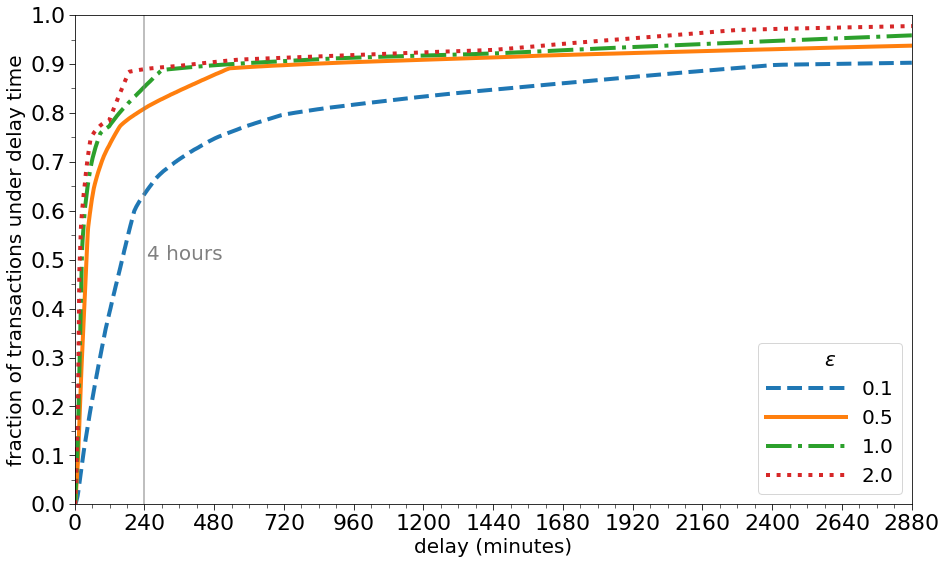

In [42]:
plot_cdf(50)

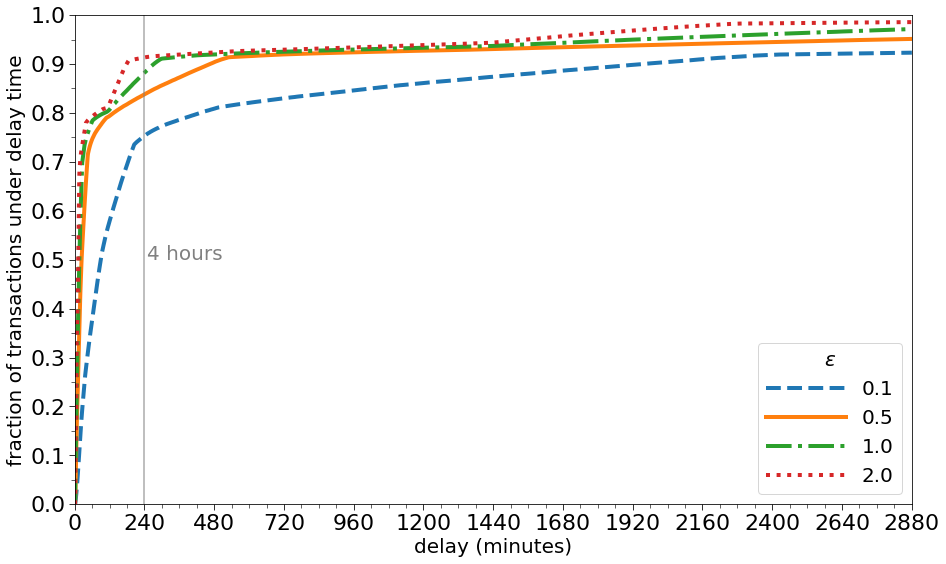

In [43]:
plot_cdf(25)

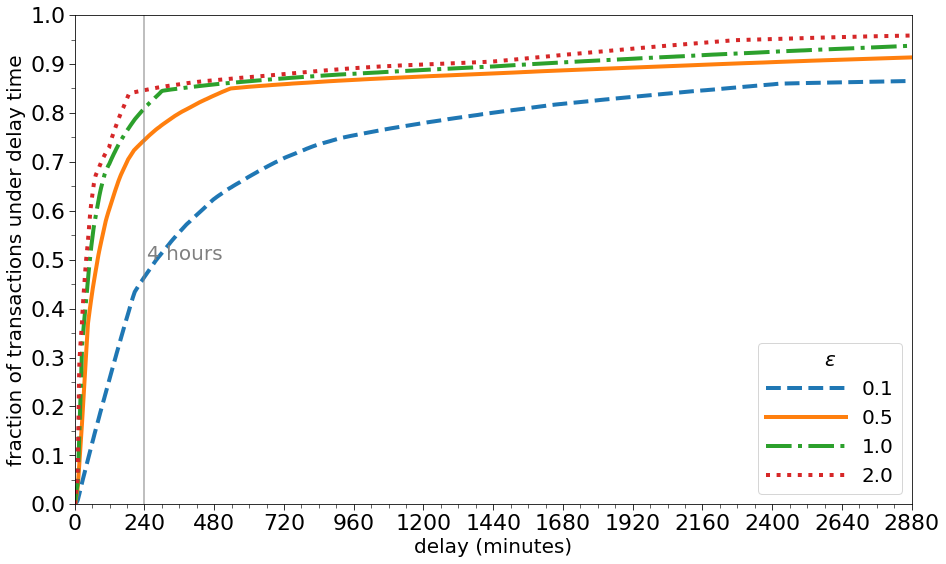

In [44]:
plot_cdf(75)

In [49]:
def eps_to_K(eps):
    return 1./(1-np.exp(-eps/2.))

In [50]:
eps_to_K(0.5)

4.520811664187799

In [51]:
eps_to_K(1)

2.5414940825367984

In [52]:
eps_to_K(0.1)

20.504166493065892

In [53]:
eps_to_K(2)

1.5819767068693265

### Attack Success

In [38]:
def plot_precision_recall(results, ax, title):
    n_TP, n_FP, n_TN, n_FN = results
    fdr = n_FP / (n_FP + n_TP)
    recall = n_TP / (n_FN + n_TP)
    
    for i in range(1,len(recall)): 
        if i == 0:
            l = 'no privacy'
        else:
            l = eps_vals[i-1]
        ax.plot(recall[i], 1.-fdr[i], label=l, lw=4, ls=next(lines))
    
    ax.set_ylabel('Precision', fontsize=22)
    ax.set_xlabel('Recall', fontsize=22)
    ax.set_title(title, fontsize=22)
    ax.set_ylim(0,1)
    
    legend = ax.legend(title=r'$\epsilon$', fontsize=22, handlelength=4)
    plt.setp(legend.get_title(),fontsize=24)
    
    ax.tick_params(axis='both', which='major', labelsize=20)

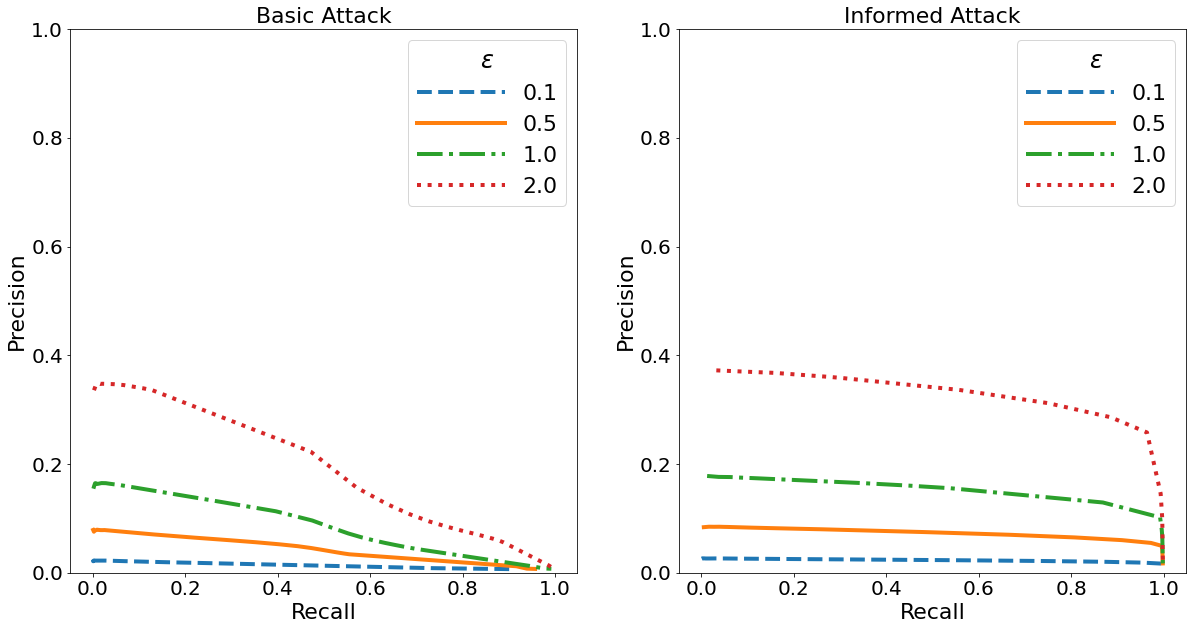

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

plot_precision_recall(results_basic[50], axes[0], 'Basic Attack')
plot_precision_recall(results_informed[50], axes[1], 'Informed Attack')
plt.show()

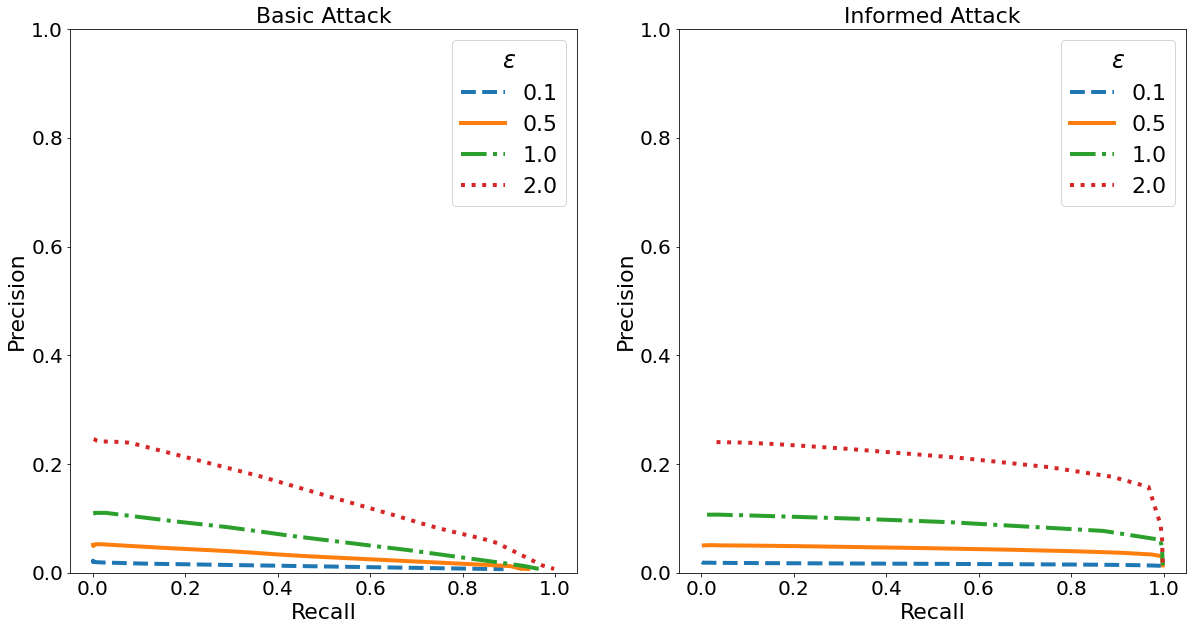

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

plot_precision_recall(results_basic[75], axes[0], 'Basic Attack')
plot_precision_recall(results_informed[75], axes[1], 'Informed Attack')
plt.show()

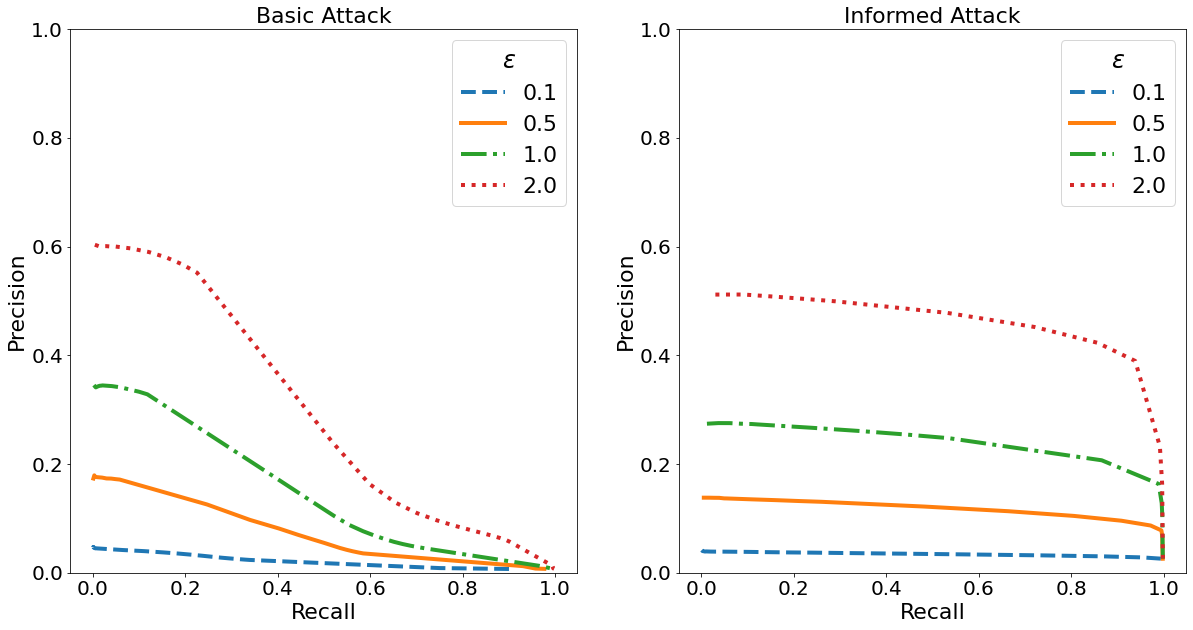

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

plot_precision_recall(results_basic[25], axes[0], 'Basic Attack')
plot_precision_recall(results_informed[25], axes[1], 'Informed Attack')
plt.show()

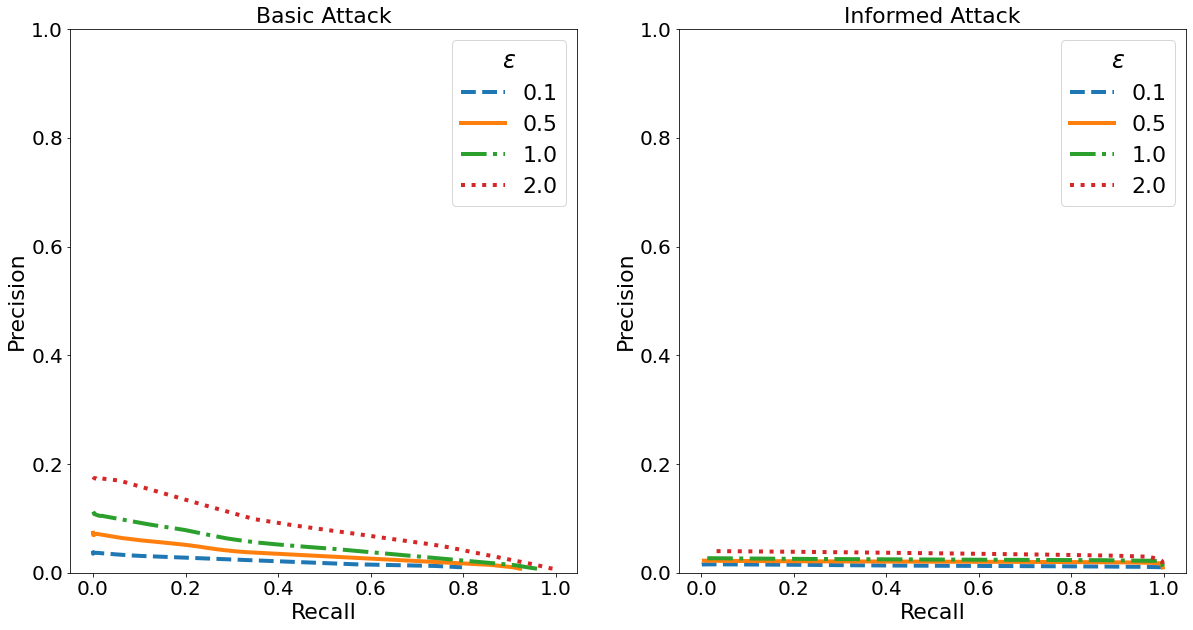

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

plot_precision_recall(results_basic[95], axes[0], 'Basic Attack')
plot_precision_recall(results_informed[95], axes[1], 'Informed Attack')
plt.show()

# Exploratory Analysis

In [2]:
%%time
df_test = load_data.load_timing_df()

CPU times: user 31 s, sys: 2.22 s, total: 33.2 s
Wall time: 33.3 s


In [3]:
df_test.head()

,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,dt_time,n_outputs,n_inputs,input_addr_str,input_value_tot_usd,output_vaue_tot_usd,is_batched,arrival_times,output_value_totusd_historical
0,"112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk,3QxZrCtQTrx...",3998,3e7d4d6dcbb25c9578e2cdd2a931c9bf5e1a6e49ad9383...,1659566303,"['35h39Pv9WsGLy3KHWhmJ5va7jxRrd6rfVm', '38b4Wg...","['112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk', '3QxZrC...",3367203540,3367188735,14805,2022-08-03 18:38:23,2,10,"35h39Pv9WsGLy3KHWhmJ5va7jxRrd6rfVm,38b4Wgtdrdn...",740784.78,740781.52,True,[1659566283.0],774722.29736
1,"112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk,3QxZrCtQTrx...",3998,f18caefefe31d2ba11f44a1efa957f5603ec576d0cee48...,1659566283,"['38d9qk6rzXGGdhEa5Kwz7EyMcfcHcb8RZz', '3NWH6Q...","['112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk', '3QxZrC...",154280138,154276253,3885,2022-08-03 18:38:03,2,2,"38d9qk6rzXGGdhEa5Kwz7EyMcfcHcb8RZz,3NWH6Qirki9...",33941.63,33940.78,True,[],774722.29736
2,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,835,16b7785b3baf60e62f73851774f5a67e2b558e7a8c90ea...,1659376517,['bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa'],['1215bzNH2G2jVcgToAaxtaC3My6BamqvVc'],10000000,9996820,3180,2022-08-01 13:55:17,1,1,bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa,2200.00,2199.30,True,[],6596.21050
3,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,835,f25b64579f6838e491199129307ebfa1f4634b47760a51...,1659376541,['1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji'],['1215bzNH2G2jVcgToAaxtaC3My6BamqvVc'],15000000,14996820,3180,2022-08-01 13:55:41,1,1,1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji,3300.00,3299.30,True,[1659376517.0],6596.21050
4,"1222XENhsyMANN7vha1m7Hg7L3aQUC24mu,bc1qw9fhylp...",2649,6deba59bc92d5ede57c775a4a63823f6a8b2a96319902e...,1659485358,"['bc1qy22cz0qgpevhhpcndgs6tuy9wel5d78de9pv7d',...","['1222XENhsyMANN7vha1m7Hg7L3aQUC24mu', 'bc1qw9...",194398,192278,2120,2022-08-02 20:09:18,2,2,"bc1qy22cz0qgpevhhpcndgs6tuy9wel5d78de9pv7d,bc1...",42.77,42.30,True,[],63.98436


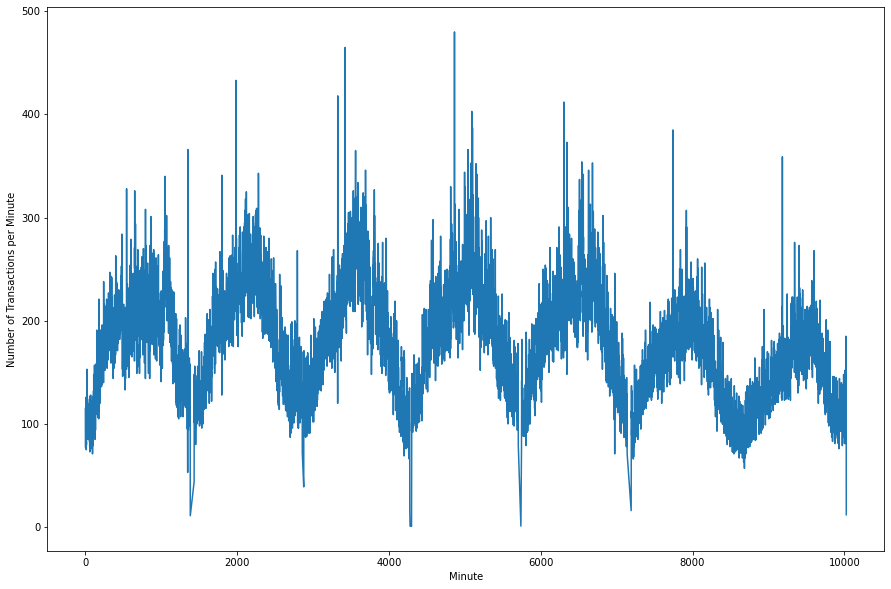

In [4]:
fig, ax = plt.subplots(figsize=(15,10))

plt.plot(df_test.groupby('epoch').count().hash)
plt.xlabel('Minute')
plt.ylabel('Number of Transactions per Minute')

plt.show()

In [5]:
df_test.shape

(1746624, 18)

In [6]:
print(df_test.dt_time.min(), df_test.dt_time.max())

2022-08-01 00:00:00 2022-08-07 23:05:05


In [14]:
print(dt.fromtimestamp(min(df_test.arrival_times.apply(lambda l: min(l) if len(l) > 0 else None))))

2022-07-25 00:00:12


In [15]:
print(dt.fromtimestamp(max(df_test.arrival_times.apply(lambda l: min(l) if len(l) > 0 else None))))

2022-08-07 23:03:04


In [16]:
df_test.head()

,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,dt_time,n_outputs,n_inputs,input_addr_str,input_value_tot_usd,output_vaue_tot_usd,is_batched,arrival_times,output_value_totusd_historical
0,"112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk,3QxZrCtQTrx...",3998,3e7d4d6dcbb25c9578e2cdd2a931c9bf5e1a6e49ad9383...,1659566303,"['35h39Pv9WsGLy3KHWhmJ5va7jxRrd6rfVm', '38b4Wg...","['112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk', '3QxZrC...",3367203540,3367188735,14805,2022-08-03 18:38:23,2,10,"35h39Pv9WsGLy3KHWhmJ5va7jxRrd6rfVm,38b4Wgtdrdn...",740784.78,740781.52,True,[1659566283.0],774722.29736
1,"112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk,3QxZrCtQTrx...",3998,f18caefefe31d2ba11f44a1efa957f5603ec576d0cee48...,1659566283,"['38d9qk6rzXGGdhEa5Kwz7EyMcfcHcb8RZz', '3NWH6Q...","['112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk', '3QxZrC...",154280138,154276253,3885,2022-08-03 18:38:03,2,2,"38d9qk6rzXGGdhEa5Kwz7EyMcfcHcb8RZz,3NWH6Qirki9...",33941.63,33940.78,True,[],774722.29736
2,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,835,16b7785b3baf60e62f73851774f5a67e2b558e7a8c90ea...,1659376517,['bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa'],['1215bzNH2G2jVcgToAaxtaC3My6BamqvVc'],10000000,9996820,3180,2022-08-01 13:55:17,1,1,bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa,2200.00,2199.30,True,[],6596.21050
3,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,835,f25b64579f6838e491199129307ebfa1f4634b47760a51...,1659376541,['1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji'],['1215bzNH2G2jVcgToAaxtaC3My6BamqvVc'],15000000,14996820,3180,2022-08-01 13:55:41,1,1,1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji,3300.00,3299.30,True,[1659376517.0],6596.21050
4,"1222XENhsyMANN7vha1m7Hg7L3aQUC24mu,bc1qw9fhylp...",2649,6deba59bc92d5ede57c775a4a63823f6a8b2a96319902e...,1659485358,"['bc1qy22cz0qgpevhhpcndgs6tuy9wel5d78de9pv7d',...","['1222XENhsyMANN7vha1m7Hg7L3aQUC24mu', 'bc1qw9...",194398,192278,2120,2022-08-02 20:09:18,2,2,"bc1qy22cz0qgpevhhpcndgs6tuy9wel5d78de9pv7d,bc1...",42.77,42.30,True,[],63.98436


In [17]:
df_test.shape

(1746624, 18)

In [18]:
df_test['n_txs_past'] = df_test.arrival_times.apply(len)

In [19]:
# % of transactions sent to outputs with past transaxtions
df_test['has_tx_history'] = df_test['n_txs_past'] >= 2
r = df_test.groupby('is_batched')['has_tx_history'].agg(['sum', 'count'])
100. * r['sum'] / r['count']

is_batched
False    12.372974
True     91.832694
dtype: float64

## Filter Out Potential Exchanges

#### Get rid of transactions over the p99 historical # of tx's and total USD value

In [20]:
past_tx_distr = df_test[df_test.n_txs_past > 0].groupby('output_addr_str').output_value_totusd_historical.max()
m_historical = np.percentile(past_tx_distr[past_tx_distr > 0], 99)

past_tx_distr_n = df_test.groupby('output_addr_str').n_txs_past.max()
m_tx_historical = np.percentile(past_tx_distr_n[past_tx_distr_n > 0], 99)

m_historical, m_tx_historical

(3427415.34662117, 25.0)

In [21]:
df_filter = df_test[df_test.is_batched & ((df_test.output_value_totusd_historical <= m_historical) | 
            (df_test.n_txs_past <= m_tx_historical))]

100. * len(df_filter) / len(df_test[df_test.is_batched])

69.40481427942933

In [22]:
addr_large = df_filter.output_addr_str.unique()
n_addr_tot = len(df_test[df_test.is_batched].output_addr_str.unique())
n_addr_tot - len(addr_large), n_addr_tot

(24, 2140)

In [23]:
len(df_filter) / 7., df_filter.output_vaue_tot_usd.sum() / 7.

(3155.1428571428573, 53200632.98428571)

#### Look at Batch Sizes

In [24]:
batch_sizes = df_filter.groupby(['epoch', 'output_addr_str'])['time'].count()

# total # of instances of batching
len(batch_sizes)

6451

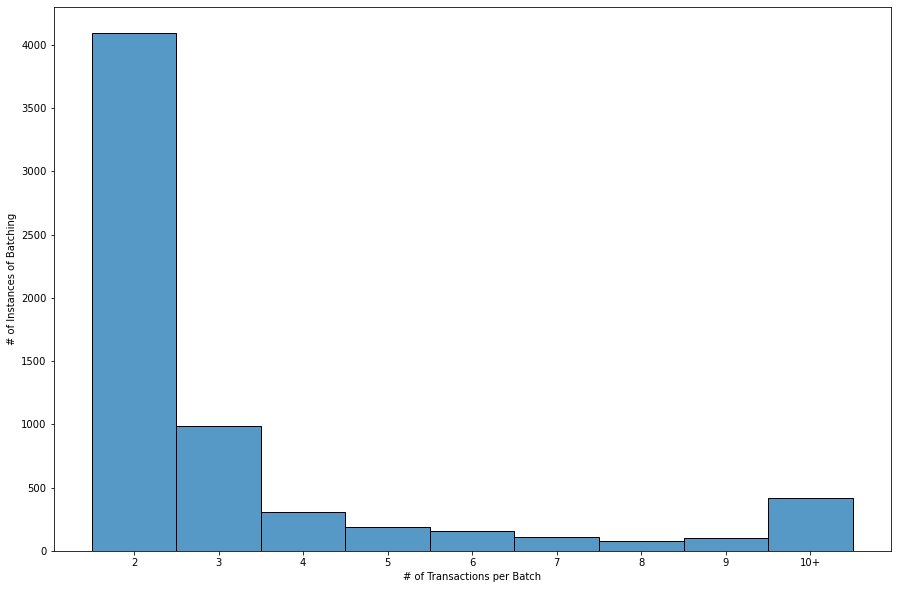

In [25]:
fig, axes = plt.subplots(figsize=(15,10))

cat = [min(b, 10) for b in batch_sizes]
sns.histplot(cat, bins = np.arange(2,12))

plt.xticks(np.arange(2,11)+0.5, labels=[str(n) for n in np.arange(2,10)] + ['10+'])

plt.ylabel('# of Instances of Batching')
plt.xlabel('# of Transactions per Batch')
plt.show()

In [26]:
len(batch_sizes[batch_sizes >= 5]), 100. * len(batch_sizes[batch_sizes >= 5]) / len(batch_sizes)

(1059, 16.416059525654937)

In [27]:
df_filter = df_filter.join(pd.DataFrame(batch_sizes), 
               on=['epoch', 'output_addr_str'], rsuffix='_tmp').rename(columns={'time_tmp': 'batch_size'})

In [28]:
df_filter = df_filter[df_filter.batch_size <= 5]

In [29]:
df_test_filter = df_test[((df_test.output_value_totusd_historical <= m_historical) | 
            (df_test.n_txs_past <= m_tx_historical))]
df_test_filter = df_test_filter[~df_test_filter.is_batched]
df_test_filter['batch_size'] = 1
df_base = pd.concat([df_test_filter, df_filter]).reset_index()

### Look at Value of g

In [222]:
df_base.head()

,index,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,...,input_addr_str,input_value_tot_usd,output_vaue_tot_usd,is_batched,arrival_times,output_value_totusd_historical,n_txs_past,has_tx_history,batch_size,epoch_T
0,31822,"1111111111111111111114oLvT2,111111111111111111...",2207,ceb08c82f543781ffcb710cb882f6f57c2135959c1d0f3...,1659458871,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",381092073,381081513,10560,...,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83840.26,83837.93,False,[],1.147132e+07,0,False,1,110
1,31823,"1111111111111111111114oLvT2,111111111111111111...",2212,80fb6a5203a0f07d6e9a3ea0993c882b5e2e99c400386d...,1659459153,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380625633,380617889,7744,...,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83737.64,83735.94,False,[2022-08-02 12:47:51],1.147132e+07,1,False,1,110
2,31824,"1111111111111111111114oLvT2,111111111111111111...",2213,b0e6be3bfd36a5c3af2f8dc9e89934ac9f2a2070cd241c...,1659459230,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380162009,380154968,7041,...,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83635.64,83634.09,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33]",1.147132e+07,2,True,1,110
3,31825,"1111111111111111111114oLvT2,111111111111111111...",2228,8c1f6ef1d494d443c2bc72bf49d2d69c687a2171ca8a86...,1659460138,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379699088,379692752,6336,...,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83533.80,83532.41,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,3,True,1,111
4,31826,"1111111111111111111114oLvT2,111111111111111111...",2229,d43583efd1e0df7f00c780a5948bc284e9d72ab82643bb...,1659460195,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379236872,379229831,7041,...,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83432.11,83430.56,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,4,True,1,111


In [30]:
cols = ['output_addr_str', 'time', 'hash']
df_tmp = df_base[cols].set_index('output_addr_str')
df_pairs = df_tmp.join(df_tmp, how='inner', lsuffix = '_1', rsuffix='_2').reset_index()
df_pairs = df_pairs[df_pairs.hash_1 < df_pairs.hash_2].reset_index()

In [42]:
df_batches = df_pairs[np.abs(df_pairs.time_1 - df_pairs.time_2) <= 60]

In [49]:
batched_hashes = set(df_batches.hash_1).union(set(df_batches.hash_2))

In [51]:
df_base['is_batched'] = False
df_base.loc[df_base.hash.isin(batched_hashes), 'is_batched'] = True

In [61]:
(df_batches.hash_1 + '.' + df_batches.hash_2)[82]

'8c1f6ef1d494d443c2bc72bf49d2d69c687a2171ca8a86978fe816598323b7d8,d43583efd1e0df7f00c780a5948bc284e9d72ab82643bbabdfcbdd3dee3d124e'

In [38]:
dt.fromtimestamp(df_pairs.time_1[4])

datetime.datetime(2022, 8, 2, 12, 47, 51)

In [39]:
dt.fromtimestamp(df_pairs.time_2[4])

datetime.datetime(2022, 8, 2, 13, 9, 55)

In [208]:
np.sum(df_base.groupby('output_addr_str').time.count() ** 2)

13125079

In [204]:
%%time

batches = get_batch_pairs(df_base,'time', 10, sample_rate=1., parallel=True)

Process ForkPoolWorker-81:
Process ForkPoolWorker-78:
Process ForkPoolWorker-82:
Process ForkPoolWorker-77:
Process ForkPoolWorker-76:
Process ForkPoolWorker-80:
Process ForkPoolWorker-79:
Traceback (most recent call last):
Process ForkPoolWorker-75:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-83:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/akgoldbe/opt/anaconda3/envs/timing/lib/python3.10/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/akgoldbe/opt/anaconda3/envs/timing/lib/python3.10/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/akgoldbe/opt/anaconda3/envs/timing/lib/python3.10/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/akgoldbe/opt/anaconda3/envs/timing/lib/python3.10/site-packages/m

In [202]:
len(batches)

3518

In [ ]:
def get_epoch(ts, start, T):
    return int(np.floor((ts - start) / (60. * T)))

start = min(df[time_col])
get_epoch(df['time']), min(df['time'], 10)

In [73]:
from multiprocess import Pool, cpu_count

def applyParallel(df, func):
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, df)
    return np.vstack(ret_list)

def applyParallelGroupBy(dfGrouped, func):
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return np.vstack(ret_list)


def get_batch_pairs(df, time_col, T):
    def get_epoch(ts, start, T):
        return int(np.floor((ts - start).total_seconds() / (60. * T)))

    start = min(df[time_col])
    # split ino epochs
    df['epoch'] = applyParallel(df[time_col], lambda t: get_epoch(t, start, 2*T))
    df_g = df.groupby(['epoch', 'output_addr_str'])[['input_addr_str', time_col]]

    def pair_and_threshold(g):
        if len(g) <= 1:
            return []
        z = list(zip(g['input_addr_str'], g['time_col']))
        return [','.join(sorted([p[0,0], p[1,0]])) for p in combinations(z, 2)
                    if np.abs(p[1][1] - p[0][1]) / 60. <= T]

    b = applyParallel(df_g, pair_and_threshold)
    return b

df_base.head()

,index,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,...,output_vaue_tot_usd,is_batched,arrival_times,output_value_totusd_historical,n_txs_past,has_tx_history,batch_size,g_75,g,g_95
0,31822,"1111111111111111111114oLvT2,111111111111111111...",2207,ceb08c82f543781ffcb710cb882f6f57c2135959c1d0f3...,1659458871,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",381092073,381081513,10560,...,83837.93,False,[],1.147132e+07,0,False,1,100000 days 00:00:00,10,100000 days 00:00:00
1,31823,"1111111111111111111114oLvT2,111111111111111111...",2212,80fb6a5203a0f07d6e9a3ea0993c882b5e2e99c400386d...,1659459153,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380625633,380617889,7744,...,83735.94,False,[2022-08-02 12:47:51],1.147132e+07,1,False,1,100000 days 00:00:00,10,100000 days 00:00:00
2,31824,"1111111111111111111114oLvT2,111111111111111111...",2213,b0e6be3bfd36a5c3af2f8dc9e89934ac9f2a2070cd241c...,1659459230,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380162009,380154968,7041,...,83634.09,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33]",1.147132e+07,2,True,1,0 days 00:04:42,5,0 days 00:04:42
3,31825,"1111111111111111111114oLvT2,111111111111111111...",2228,8c1f6ef1d494d443c2bc72bf49d2d69c687a2171ca8a86...,1659460138,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379699088,379692752,6336,...,83532.41,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,3,True,1,0 days 00:03:50.750000,5,0 days 00:04:31.750000
4,31826,"1111111111111111111114oLvT2,111111111111111111...",2229,d43583efd1e0df7f00c780a5948bc284e9d72ab82643bb...,1659460195,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379236872,379229831,7041,...,83430.56,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,4,True,1,0 days 00:09:55,15,0 days 00:14:05.400000


In [36]:
D_MAX = timedelta(days=100000)

def compute_g_percentile(times, p=75):
    diffs = np.diff(times)
    zeros = sum(diffs <= 60)
    if zeros == len(diffs):
        return D_MAX
    else:
        return np.percentile(diffs[diffs != timedelta(0)], p)

df_base['g_75'] = df_base.arrival_times.apply(compute_g_percentile)

In [22]:
def bucket_time(t):
    if t == D_MAX:
        return 5
    if t <= timedelta(minutes = 60):
        return 0
    if t <= timedelta(minutes = 60*12):
        return 1
    if t <= timedelta(minutes = 60*24):
        return 2
    if t <= timedelta(minutes = 60*48):
        return 3
    return 4

time_labels = ['<1 hr', '1-12 hrs', '12-24 hrs', '1-2 days', '>2 days', 'Infinite\n(No other tx)']

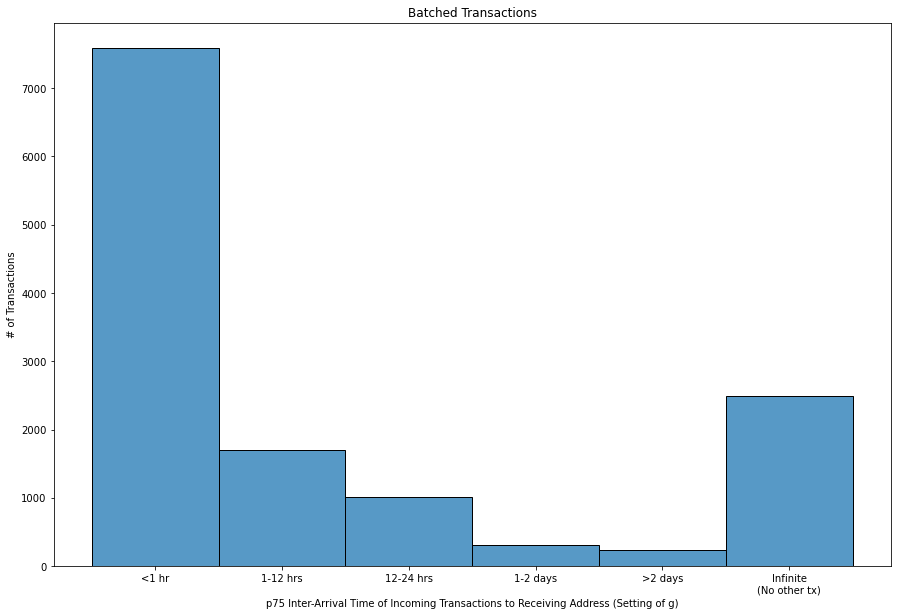

In [23]:
fig, axes = plt.subplots(figsize=(15,10))
sns.histplot(df_base[df_base.is_batched].g_75.apply(bucket_time), bins = np.arange(0,7))
plt.xticks(np.arange(0,6)+0.5, labels=time_labels)
plt.ylabel('# of Transactions')
plt.xlabel('p75 Inter-Arrival Time of Incoming Transactions to Receiving Address (Setting of g)')
plt.title('Batched Transactions')
plt.show()

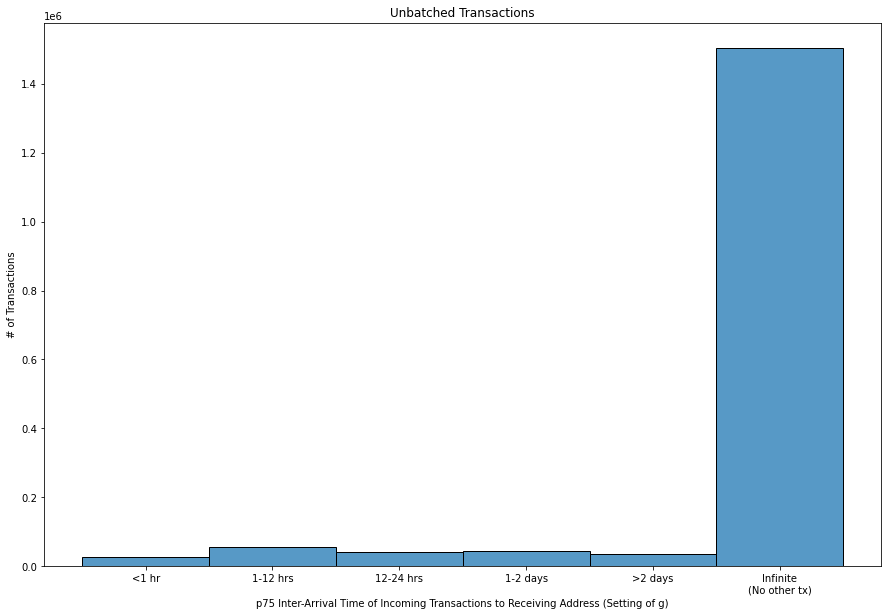

In [24]:
fig, axes = plt.subplots(figsize=(15,10))
sns.histplot(df_base[~df_base.is_batched].g_75.apply(bucket_time), bins = np.arange(0,7))
plt.xticks(np.arange(0,6)+0.5, labels=time_labels)
plt.ylabel('# of Transactions')
plt.xlabel('p75 Inter-Arrival Time of Incoming Transactions to Receiving Address (Setting of g)')
plt.title('Unbatched Transactions')
plt.show()

### Simulate Mechanisms

In [35]:
df_base.head()

,index,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,...,n_inputs,input_addr_str,input_value_tot_usd,output_vaue_tot_usd,is_batched,arrival_times,output_value_totusd_historical,n_txs_past,has_tx_history,batch_size
0,31822,"1111111111111111111114oLvT2,111111111111111111...",2207,ceb08c82f543781ffcb710cb882f6f57c2135959c1d0f3...,1659458871,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",381092073,381081513,10560,...,1,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83840.26,83837.93,False,[],1.147132e+07,0,False,1
1,31823,"1111111111111111111114oLvT2,111111111111111111...",2212,80fb6a5203a0f07d6e9a3ea0993c882b5e2e99c400386d...,1659459153,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380625633,380617889,7744,...,1,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83737.64,83735.94,False,[2022-08-02 12:47:51],1.147132e+07,1,False,1
2,31824,"1111111111111111111114oLvT2,111111111111111111...",2213,b0e6be3bfd36a5c3af2f8dc9e89934ac9f2a2070cd241c...,1659459230,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380162009,380154968,7041,...,1,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83635.64,83634.09,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33]",1.147132e+07,2,True,1
3,31825,"1111111111111111111114oLvT2,111111111111111111...",2228,8c1f6ef1d494d443c2bc72bf49d2d69c687a2171ca8a86...,1659460138,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379699088,379692752,6336,...,1,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83533.80,83532.41,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,3,True,1
4,31826,"1111111111111111111114oLvT2,111111111111111111...",2229,d43583efd1e0df7f00c780a5948bc284e9d72ab82643bb...,1659460195,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379236872,379229831,7041,...,1,14p19AeJg6NubeQTa8bF2TpgbprcoivyrS,83432.11,83430.56,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,4,True,1


In [45]:
def eps_to_K(eps):
    return max(1, np.ceil(1./(np.exp(eps/2.) -1)))

def K_to_eps(K):
    return 2*np.log((K+1.) / K)

def sample_staircase(eps, g, gamma=None, size=1):
    # if gamma = None, use OPT
    if gamma is None:
        gamma = 1/(1+np.exp(eps/2.))
    b = np.exp(-1.*eps)
    G = geom.rvs(1-b, loc=-1, size=size)
    U = uniform.rvs(size=size)
    p0 = gamma / (gamma + ((1-gamma)*b))
    B = bernoulli.rvs(1.-p0, size=size)
    return (1-B)*((G + gamma*U)*g) + B*((G + gamma + ((1-gamma)*U))*g)

def apply_rand_staircase(is_batched, g, eps):
    d = sample_staircase(eps / 2., g)[0]
    if is_batched:
        return g + d
    else:
        return d
    
def apply_rand_epoch(is_batched, g, K):
    if is_batched:
        # sample from g to g(K+1)
        loc = g
        scale = K*g
    else:
        # sample from 0 to g(K+1)
        loc = 0
        scale = (K+1)*g
    return uniform.rvs(loc=loc, scale=scale) 

def td_to_timestep(t):
    return int(np.ceil(t.total_seconds() / 60.))

def test_delays(eps, iters=5, batched_only=True):
    if batched_only:
        df = df_base[df_base.is_batched]
    else:
        df = df_base
    
    stair_runs = []
    epoch_runs = []
    for i in range(iters):
        stair_runs += [df.apply(lambda r: apply_rand_staircase(r['is_batched'], r['g'], eps), axis=1)]
        epoch_runs += [df.apply(lambda r: apply_rand_epoch(r['is_batched'], r['g'], K_to_eps(eps)), axis=1)]
    
    return stair_runs, epoch_runs

def plot_delays(stair_runs, epoch_runs, cutoff=95, ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,10))
    
    s = np.hstack(stair_runs)
    e = np.hstack(epoch_runs)
    
    x_max = 300
    
    ax.hist([e, s], bins=np.arange(0, x_max, 10), alpha=0.9, label=['random epoch', 'staircase'], density=True)
    
    ax.legend(fontsize=16)
        
    ax.set_xlabel('Number of Minutes Delayed')
    ax.set_ylabel('Density')
    
def get_percentiles(stair_runs, epoch_runs, eps_value):
    p25 = np.percentile(stair_runs, 25), np.percentile(epoch_runs, 25)
    p50 = np.percentile(stair_runs, 50), np.percentile(epoch_runs, 50)
    p75 = np.percentile(stair_runs, 75), np.percentile(epoch_runs, 75)
    p95 = np.percentile(stair_runs, 95), np.percentile(epoch_runs, 95)
    avg = np.mean(stair_runs), np.mean(epoch_runs)

    d = pd.DataFrame([p25, p50, p75, p95, avg]).T
    d.index = ['Staircase', 'Random Epoch']
    d.columns= ['p25', 'p50', 'p75', 'p95', 'Mean']
    eps = r'$\epsilon$'
    d[eps] = eps_value
    d.set_index(eps, append=True, inplace=True)
    return d.round(decimals=1)

def get_epoch(ts, start, D):
    return int(np.floor((ts - start).total_seconds() / (60. * D)))

def get_batch_pairs(grouped):
    return [','.join(sorted(p)) for c in grouped.values if len(c) > 1 for p in combinations(c, 2)]

BATCHES = set(get_batch_pairs(df_base.groupby(['epoch', 'output_addr_str'])['input_addr_str'].apply(list)))

def simulate_attack(df, T, batches=BATCHES, informed=False):
    df['epoch_T_priv'] = [get_epoch(ts, start_dt, D) for ts in df['release_time']]
    priv_batches = df_base.groupby(['epoch_T_priv', 'output_addr_str'])['input_addr_str'].apply(list)
    pairs_priv = set(get_batch_pairs(priv_batches))
    n_TP = len(pairs_orig.intersection(pairs_priv))
    n_FP = len(pairs_priv) - n_TP
    n_FN = len(pairs_orig) - n_TP
    recall = n_TP / (n_FN + n_TP)
    precision = n_TP / (n_TP + n_FP)
    print(f'TP: {n_TP}, FP: {n_FP}, FN: {n_FN}')
    print(f'Recall: {n_TP / (n_FN + n_TP)}, Precision: {n_TP / (n_TP + n_FP)}')
    return n_TP, n_FP, n_FN, recall, precision

def run_experiment(g_perc, eps, DEFAULT_G = 10, iters=5):
    df_base[f'g_{g_perc}'] = df_base.arrival_times.apply(lambda t: compute_g_percentile(t, g_perc))
    df_base['g'] = [DEFAULT_G if g == D_MAX else td_to_timestep(g) for g in df_base[f'g_{g_perc}']]
    
    stair_runs, epoch_runs = test_delays(eps, iters, batched_only=False)
    df['release_time'] = (epoch_runs[0] * 60) + df.timestamp
    simulate_attack(df, )

In [57]:
df_base[f'g_{95}'] = df_base.arrival_times.apply(lambda t: compute_g_percentile(t, 95))
df_base['g'] = [DEFAULT_G if g == D_MAX else td_to_timestep(g) for g in df_base[f'g_{95}']]

In [50]:
K =  K_to_eps(eps)
stair_runs, epoch_runs = df_base.apply(lambda r: apply_rand_epoch(r['is_batched'], r['g'], K), axis=1)

In [66]:
dt.fromtimestamp(1659458871 + 3600)

datetime.datetime(2022, 8, 2, 13, 47, 51)

In [ ]:
df.tim

In [60]:
df_base.head()

,index,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,...,output_vaue_tot_usd,is_batched,arrival_times,output_value_totusd_historical,n_txs_past,has_tx_history,batch_size,g_75,g,g_95
0,31822,"1111111111111111111114oLvT2,111111111111111111...",2207,ceb08c82f543781ffcb710cb882f6f57c2135959c1d0f3...,1659458871,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",381092073,381081513,10560,...,83837.93,False,[],1.147132e+07,0,False,1,100000 days 00:00:00,10,100000 days 00:00:00
1,31823,"1111111111111111111114oLvT2,111111111111111111...",2212,80fb6a5203a0f07d6e9a3ea0993c882b5e2e99c400386d...,1659459153,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380625633,380617889,7744,...,83735.94,False,[2022-08-02 12:47:51],1.147132e+07,1,False,1,100000 days 00:00:00,10,100000 days 00:00:00
2,31824,"1111111111111111111114oLvT2,111111111111111111...",2213,b0e6be3bfd36a5c3af2f8dc9e89934ac9f2a2070cd241c...,1659459230,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",380162009,380154968,7041,...,83634.09,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33]",1.147132e+07,2,True,1,0 days 00:04:42,5,0 days 00:04:42
3,31825,"1111111111111111111114oLvT2,111111111111111111...",2228,8c1f6ef1d494d443c2bc72bf49d2d69c687a2171ca8a86...,1659460138,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379699088,379692752,6336,...,83532.41,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,3,True,1,0 days 00:03:50.750000,5,0 days 00:04:31.750000
4,31826,"1111111111111111111114oLvT2,111111111111111111...",2229,d43583efd1e0df7f00c780a5948bc284e9d72ab82643bb...,1659460195,['14p19AeJg6NubeQTa8bF2TpgbprcoivyrS'],"['1111111111111111111114oLvT2', '1111111111111...",379236872,379229831,7041,...,83430.56,False,"[2022-08-02 12:47:51, 2022-08-02 12:52:33, 202...",1.147132e+07,4,True,1,0 days 00:09:55,15,0 days 00:14:05.400000


In [56]:
df_base['epoch'] + epoch_runs

0           2241.093998
1           2250.507335
2           2216.562209
3           2238.888656
4           2252.205958
               ...     
1720970    17205.576034
1720971    16019.747530
1720972     6338.101157
1720973     1962.774986
1720974     1950.810538
Length: 1720975, dtype: float64

#### Utility (Staircase vs. Uniform)

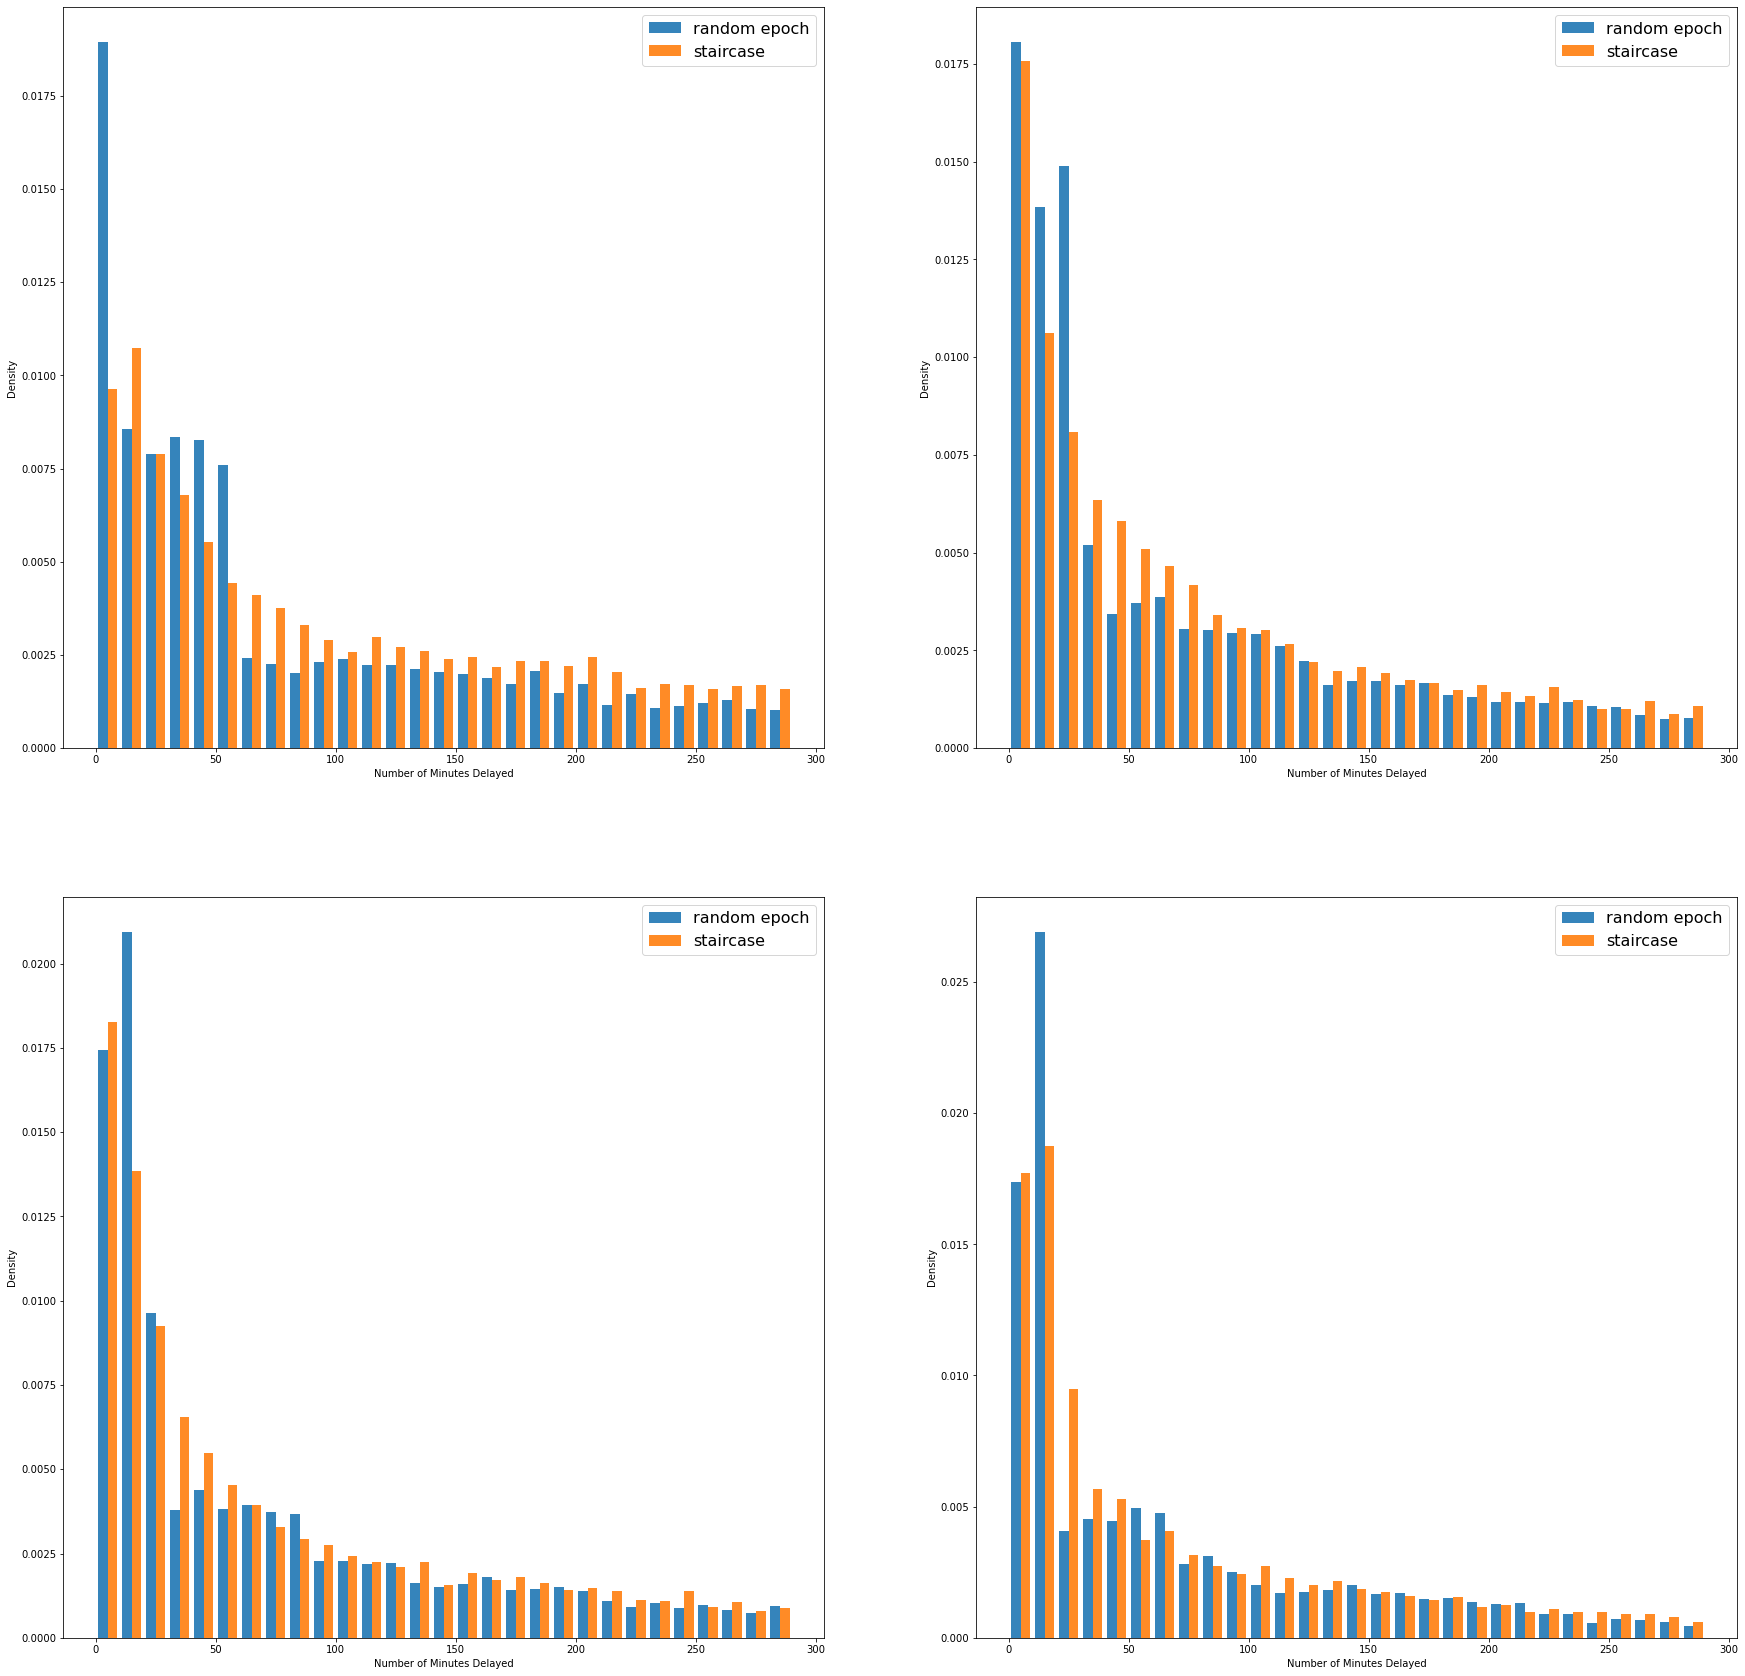

In [58]:
EPS = [0.1, 0.5, 1., 2.]

fig, axes = plt.subplots(2, 2, figsize=(30, 30))

ds = []
for i, ax in enumerate(axes.ravel()):
    eps = EPS[i]
    stair_runs, epoch_runs = test_delays(eps, iters=1)
    ds += [get_percentiles(stair_runs, epoch_runs, eps)]
    plot_delays(stair_runs, epoch_runs, cutoff=50, ax=ax)

plt.show()

In [59]:
print(pd.concat(ds).style.format(thousands=',', precision=1).to_latex())

\begin{tabular}{llrrrrr}
 &  & p25 & p50 & p75 & p95 & Mean \\
 & $\epsilon$ &  &  &  &  &  \\
Staircase & 0.100000 & 134.3 & 668.9 & 4,494.0 & 67,245.2 & 12,008.7 \\
Random Epoch & 0.100000 & 36.5 & 158.5 & 778.2 & 10,994.6 & 1,924.7 \\
Staircase & 0.500000 & 41.3 & 185.8 & 1,173.6 & 15,545.9 & 2,781.8 \\
Random Epoch & 0.500000 & 22.9 & 102.3 & 460.6 & 6,514.2 & 1,190.1 \\
Staircase & 1.000000 & 26.3 & 127.5 & 701.1 & 9,464.8 & 1,693.4 \\
Random Epoch & 1.000000 & 18.2 & 83.7 & 362.4 & 5,269.3 & 962.1 \\
Staircase & 2.000000 & 19.0 & 90.5 & 449.8 & 6,289.4 & 1,122.9 \\
Random Epoch & 2.000000 & 14.9 & 69.3 & 295.0 & 4,345.8 & 791.7 \\
\end{tabular}



## Test Attack Empirically

### Basic Attack - TP vs. FP

In [125]:
n_TP = len(pairs_orig.intersection(pairs_priv))
n_FP = len(pairs_priv) - n_TP
n_FN = len(pairs_orig) - n_TP
print(f'TP: {n_TP}, FP: {n_FP}, FN: {n_FN}')
print(f'Recall: {n_TP / (n_FN + n_TP)}, Precision: {n_TP / (n_TP + n_FP)}')

TP: 4553, FP: 21727, FN: 6562
Recall: 0.40962663067926225, Precision: 0.1732496194824962
